# Decoding the belief state from a value RNN

In [1]:
import os
import numpy as np; np.set_printoptions(linewidth=150)
import torch; torch.set_printoptions(linewidth=150)
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from environment import CliffWalk
from episodes import Episode, collect_episodes, EpisodeCollection
from belief_decoders import NonLinBeliefDecoder, LinBeliefDecoder, train_belief_decoder, plot_decoded_belief_over_nuisance, plot_decoded_belief_over_true, evaluate_belief

In [3]:
class HMM():
    def __init__(self, TPM, OPM, ISD):
        
        assert TPM.shape[0] == TPM.shape[1], "TPM must be square"
        assert OPM.shape[0] == TPM.shape[0], "OPM must have same number of rows as TPM"
        assert ISD.shape[0] == TPM.shape[0], "ISD must have same number of rows as TPM"

        self.TPM = TPM # Transition Probability Matrix
        self.OPM = OPM # Observation Probability Matrix
        self.ISD = ISD # Initial State Distribution

        self.n_states   = self.TPM.shape[0]
        self.n_obs      = self.OPM.shape[1]

        self.running = False

    def reset(self):
        self.state  = np.random.choice(self.n_states, p=self.ISD)
        observation = np.random.choice(self.n_obs,    p=self.OPM[self.state,:])
        self.running = True
        return self.state, observation

    def step(self):
        if not self.running:
            self.reset()
        self.state  = np.random.choice(self.n_states, p=self.TPM[self.state,:])
        observation = np.random.choice(self.n_obs,    p=self.OPM[self.state,:])

        return self.state, observation
    
    def run(self, n_steps):
        states = np.zeros((n_steps, self.n_states))
        observations = np.zeros((n_steps, self.n_obs))

        for i in range(n_steps):
            state_i, observation_i = self.step()
            states[i, state_i] = 1
            observations[i, observation_i] = 1

        return states, observations
    
    def filtering(self, observations_onehot):
        """
        Forward algorithm for filtering
        """
        n_obs = observations_onehot.shape[0]

        belief_states = []
        # Calculate initial belief state from the prior distribution and the first observation
        belief = self.ISD * self.OPM[:, np.argmax(observations_onehot[0])]
        belief /= np.sum(belief)
        belief_states.append(belief)
        
        for t in range(1, n_obs):
            new_belief = belief @ self.TPM
            new_belief *= self.OPM[:, np.argmax(observations_onehot[t])]
            new_belief /= np.sum(new_belief)
            belief = new_belief
            belief_states.append(belief)

        belief_states = np.array(belief_states)
        return belief_states

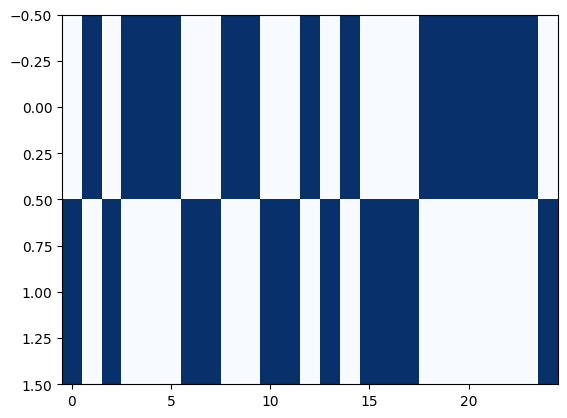

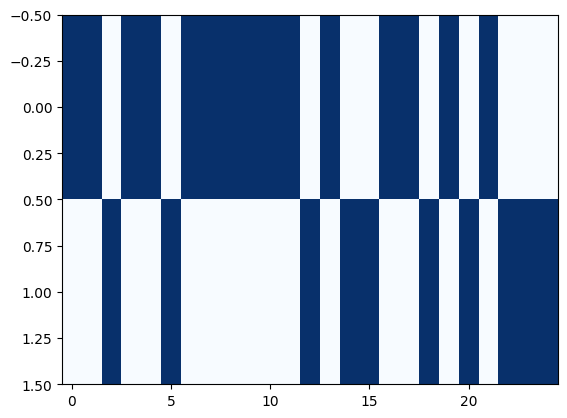

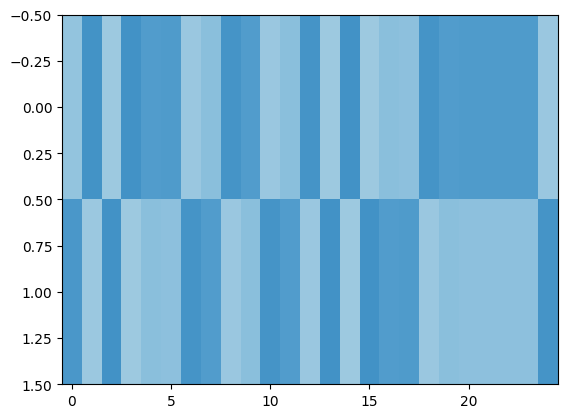

In [4]:
TPM = np.array([[0.4, 0.6],
                [0.6, 0.4]])
OPM = np.array([[0.6, 0.4], 
                [0.4, 0.6]])
ISD = np.array([0.5, 0.5])  # Start in state 0 with probability 1

hmm = HMM(TPM, OPM, ISD)

n_steps = 25
states, observations = hmm.run(n_steps)
belief_states = hmm.filtering(observations)

plt.imshow(observations.T, aspect='auto', cmap='Blues')
plt.show()
plt.imshow(states.T, aspect='auto', cmap='Blues')
plt.show()
plt.imshow(belief_states.T, aspect='auto', cmap='Blues', vmin=0, vmax=1)
plt.show()

In [5]:
# TD loss function
def td_loss(values, rewards, mask_traj, lengths, gamma=1.0):
    
    # calculate the TD target
    values_next = torch.zeros_like(values)
    values_next[:, :-1] = values[:, 1:]
    for b, l in enumerate(lengths): # TD target at last value should only be the reward
        values_next[b, l-1] = 0.0
    td_target = rewards + (gamma * values_next.detach())
    
    # Calculate the TD error
    td_error = ((values - td_target) ** 2) * mask_traj
    loss = td_error.sum() / mask_traj.sum()  # average loss over non-masked values
    
    return loss


def mc_loss(values, returns, mask_monte_carlo):
    # Compute the mc loss only at start and terminal states
    mc_values = values * mask_monte_carlo
    mc_returns = returns * mask_monte_carlo
    
    # Set first state return to the average of all first states
    start_state_return = mc_returns[:, 0].mean()
    mc_returns[:, 0] = start_state_return  

    mc_error = (mc_values - mc_returns) ** 2

    mc_loss = mc_error.sum() / mask_monte_carlo.sum()  # average loss over non-masked values

    return mc_loss

def evaluate_episode(model, episode):
    model.eval()  # switch to eval mode

    with torch.no_grad():
        history = torch.tensor(episode.history, dtype=torch.float32).unsqueeze(0)  # shape: [1, T, D]
        length = [history.shape[1]]  # length = [T]
        mask = torch.ones((1, history.shape[1]), dtype=torch.float32)

        predicted_values, _ = model(history, mask)  # shape: [1, T]
        return predicted_values.squeeze(0).numpy()  # shape: [T]
    
def validate(model, test_episode, value, indices):
    true_values = test_episode.belief_states[:,indices[0]:indices[1]] @ value
    true_values = np.round(true_values, 2)
    
    values = evaluate_episode(model, test_episode)
    values = np.round(values, 2)

    print("True Values:")
    print(true_values)
    print("Predicted Values:")
    print(values)
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='True Values', marker='o')
    plt.plot(values, label='Predicted Values', marker='x')
    plt.title("True vs Predicted Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()



def save_checkpoint(model, epoch, checkpoint_dir="checkpoints", filename=None):
    os.makedirs(checkpoint_dir, exist_ok=True)
    if filename is None:
        filename = f"checkpoint_epoch_{epoch}.pth"
    path = os.path.join(checkpoint_dir, filename)
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Saved checkpoint: {path}")


In [ ]:
# Define the RNN-based value estimator
class ValueRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        # RNN to process the history of observations and actions
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        # Head to output the value for each time step from the RNN output
        self.head = nn.Sequential(
            # nn.Linear(hidden_dim, 64),
            # nn.ReLU(),
            # nn.Linear(64, 1)
            nn.Linear(hidden_dim, 1)
        )

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
    
    def forward(self, x, mask):
        hidden_states, _ = self.rnn(x)  # [B, T, H]
        
        # Calculate the output values for each time step
        values = self.head(hidden_states)  # [B, T, 1]
        values = values.squeeze(-1)  # [B, T]
        values = values * mask  # Apply the mask to the output

        return values, hidden_states
    
# Training loop
def train(model, episodes, test_episode, value=None, num_epochs=10, gamma=1.0, lr=1e-3, validate_every=500, batch_size=32, indices=[0, None]):
    
    # Set up input and target tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available
    
    histories   = episodes.batch_histories.to(device) 
    rewards     = episodes.batch_rewards.to(device) 
    mask_traj   = episodes.batch_mask_traj.to(device)  
    mask_mc     = episodes.batch_mask_mc.to(device)
    

    mc_returns  = episodes.get_monte_carlo_returns(gamma).to(device)  
    ep_lengths  = episodes.ep_lengths

    # Validate dimensions
    assert model.input_dim == histories.shape[-1], f"Model input dimension {model.input_dim} does not match history dimension {histories.shape[-1]}"

    # Set up the value estimator model
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    model.train()

    for epoch in range(num_epochs):
        # Validate and save the model every `validate_every` epochs
        if (epoch) % validate_every == 0:
            model.to('cpu') 
            validate(model, test_episode, value, indices)
            save_checkpoint(model, epoch)
            model.to(device)
            model.train()

        # choose "batch_size" random episodes from the dataset
        chosen_i = np.random.choice(len(episodes), size=min(batch_size, len(episodes)), replace=False)
        batch_lengths = [ep_lengths[i] for i in chosen_i]

        # Calculate the estimated values
        optimizer.zero_grad()
        pred_values, _ = model(histories[chosen_i], mask_traj[chosen_i])  # shape: [B, T]
        
        # Calculate losses, and combine them
        td_L = td_loss(pred_values, rewards[chosen_i], mask_traj[chosen_i], batch_lengths, gamma)
        mc_L = mc_loss(pred_values, mc_returns[chosen_i], mask_mc[chosen_i])
        loss = td_L + mc_L 
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print losses
        td_L = np.round(np.sqrt(td_L.item()), 2)
        mc_L = np.round(np.sqrt(mc_L.item()), 2)
        loss = np.round(td_L + mc_L, 2)
        print(f"Epoch {epoch+1}, TD Loss: {td_L}, MC Loss: {mc_L}, Total: {loss}     ", end= '\r')
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, TD Loss: {td_L}, MC Loss: {mc_L}, Total: {loss}     ")
         
    model.to('cpu')  # Move model back to CPU after training

## Collect Data

In [7]:
TPM = np.array([[0.1, 0.9],
                [0.9, 0.1]])
OPM = np.array([[0.6, 0.4], 
                [0.4, 0.6]])
ISD = np.array([0.5, 0.5])  # Start in state 0 with probability 1

hmm = HMM(TPM, OPM, ISD)

def pollute_episode_with_hmm(episode:Episode, hmm:HMM) -> Episode:
    time_steps = len(episode.history)
    states, observations = hmm.run(time_steps)
    belief_states = hmm.filtering(observations)
    
    hmm_data = np.array(observations)

    episode.observations    = np.concatenate((hmm_data, episode.observations), axis=1)        # Append HMM observations to the episode
    episode.history         = np.concatenate((hmm_data, episode.history), axis=1)             # Append HMM observations to the history
    episode.belief_states   = np.concatenate((belief_states, episode.belief_states), axis=1)  # Append HMM belief states to the episode

    return episode

Empirical Value function:
[[-18.81 -17.36 -15.45 -14.28 -12.33 -10.85  -8.32  -5.27]
 [-17.23 -15.38 -14.13 -12.62 -11.23  -9.93  -7.49  -3.18]
 [-17.83 -10.   -10.   -10.   -10.   -10.   -10.     0.  ]]


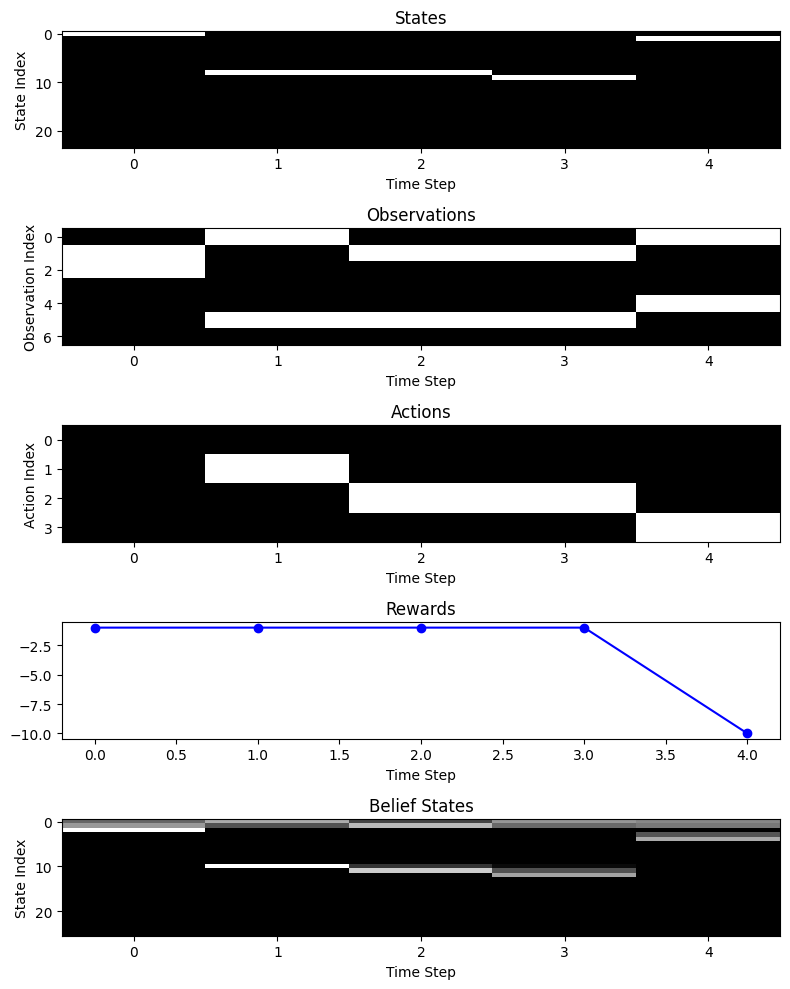

In [31]:
# Set up env
N, M = 3, 8
cliff = CliffWalk(n=N, m=M, self_transition_prob=0.2, gamma=1.0)
# Set up target policy
policy = cliff.get_optimal_policy(epsilon=0.3)

# Collect episodes from the environment using the target policy
episode_list = collect_episodes(cliff, policy, num_episodes=500)

for episode in episode_list: # Pollute the episodes with observations from the HMM
    episode = pollute_episode_with_hmm(episode, hmm)
belief_dim_i = {'true':[2, None], 'nuisance':[0, 2]}

episodes = EpisodeCollection(episode_list)

print("Empirical Value function:")
value_empirical = episodes.get_monte_carlo_values(gamma=cliff.gamma)
print(np.flip(value_empirical.reshape((cliff.n, cliff.m)), axis=0))

# Get a test episode to validate the model
test_episode = collect_episodes(cliff, policy, num_episodes=1)[0]
test_episode = pollute_episode_with_hmm(test_episode, hmm)
test_episode.render()

## Train Model

True Values:
[-17.89 -17.89 -17.17 -17.89 -17.89 -17.89 -17.17 -15.83 -14.7  -13.57 -12.39 -11.06  -9.52  -7.52  -5.69   0.  ]
Predicted Values:
[0.14 0.13 0.19 0.23 0.19 0.19 0.23 0.29 0.32 0.33 0.35 0.35 0.35 0.37 0.36 0.4 ]


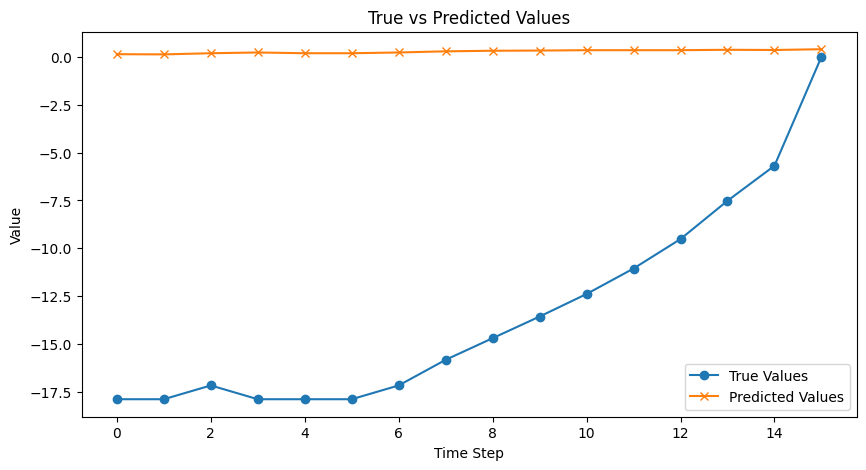

Saved checkpoint: checkpoints/checkpoint_epoch_0.pth
Epoch 50, TD Loss: 2.05, MC Loss: 12.95, Total: 15.0      
Epoch 100, TD Loss: 2.45, MC Loss: 12.01, Total: 14.46     
Epoch 150, TD Loss: 2.78, MC Loss: 10.9, Total: 13.68      
Epoch 200, TD Loss: 2.51, MC Loss: 9.14, Total: 11.65      
Epoch 250, TD Loss: 2.06, MC Loss: 6.24, Total: 8.3       
Epoch 300, TD Loss: 1.61, MC Loss: 3.65, Total: 5.26     
Epoch 350, TD Loss: 1.67, MC Loss: 2.12, Total: 3.79     
Epoch 400, TD Loss: 1.84, MC Loss: 1.38, Total: 3.22     
Epoch 450, TD Loss: 1.84, MC Loss: 1.06, Total: 2.9      
Epoch 500, TD Loss: 1.68, MC Loss: 0.8, Total: 2.48      
True Values:
[-17.89 -17.89 -17.17 -17.89 -17.89 -17.89 -17.17 -15.83 -14.7  -13.57 -12.39 -11.06  -9.52  -7.52  -5.69   0.  ]
Predicted Values:
[-17.61 -15.68 -15.49 -14.69 -16.56 -16.12 -15.54 -14.62 -13.89 -13.3  -12.14 -10.97  -9.57  -8.26  -7.48  -0.18]


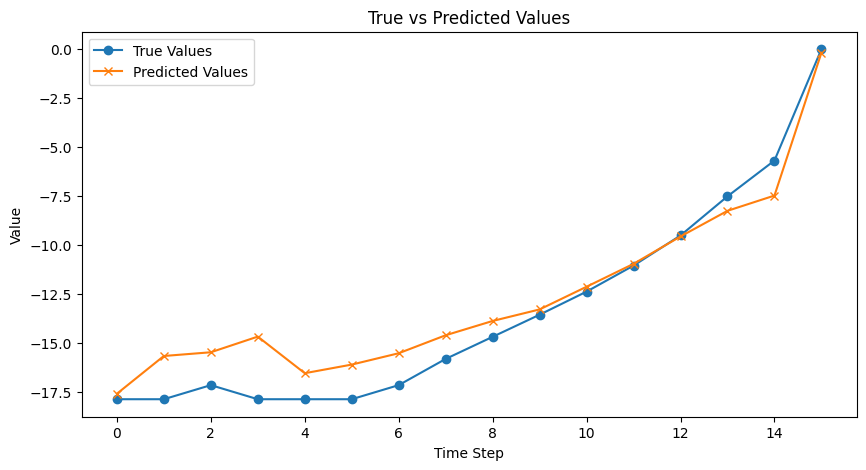

Saved checkpoint: checkpoints/checkpoint_epoch_500.pth
Epoch 550, TD Loss: 1.59, MC Loss: 0.59, Total: 2.18     
Epoch 600, TD Loss: 1.55, MC Loss: 0.43, Total: 1.98     
Epoch 650, TD Loss: 1.55, MC Loss: 0.33, Total: 1.88     
Epoch 700, TD Loss: 1.55, MC Loss: 0.26, Total: 1.81     
Epoch 750, TD Loss: 1.57, MC Loss: 0.22, Total: 1.79     
Epoch 800, TD Loss: 1.57, MC Loss: 0.19, Total: 1.76     
Epoch 850, TD Loss: 1.56, MC Loss: 0.17, Total: 1.73     
Epoch 900, TD Loss: 1.56, MC Loss: 0.16, Total: 1.72     
Epoch 950, TD Loss: 1.56, MC Loss: 0.15, Total: 1.71     
Epoch 1000, TD Loss: 1.56, MC Loss: 0.14, Total: 1.7     
True Values:
[-17.89 -17.89 -17.17 -17.89 -17.89 -17.89 -17.17 -15.83 -14.7  -13.57 -12.39 -11.06  -9.52  -7.52  -5.69   0.  ]
Predicted Values:
[-18.01 -17.62 -17.28 -16.47 -18.01 -17.77 -17.4  -15.78 -14.66 -13.54 -12.24 -10.87  -9.52  -7.98  -6.26   0.08]


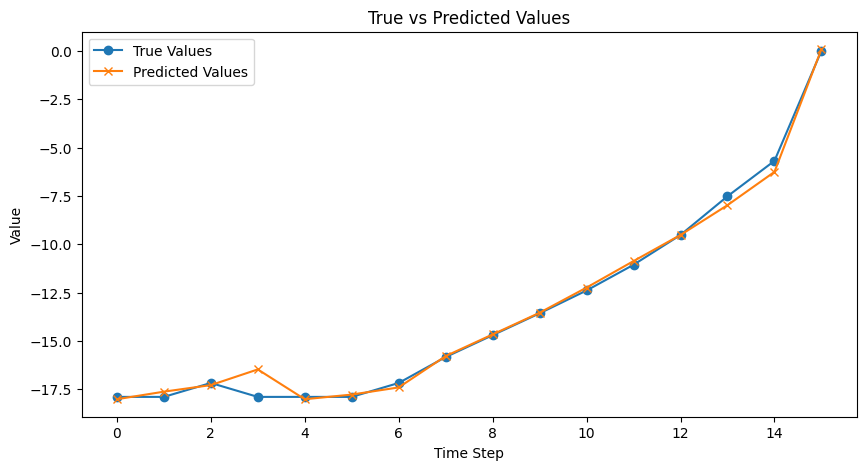

Saved checkpoint: checkpoints/checkpoint_epoch_1000.pth
Epoch 1050, TD Loss: 1.55, MC Loss: 0.14, Total: 1.69     
Epoch 1100, TD Loss: 1.55, MC Loss: 0.13, Total: 1.68     
Epoch 1150, TD Loss: 1.55, MC Loss: 0.12, Total: 1.67     
Epoch 1200, TD Loss: 1.54, MC Loss: 0.12, Total: 1.66     
Epoch 1250, TD Loss: 1.54, MC Loss: 0.12, Total: 1.66     
Epoch 1300, TD Loss: 1.53, MC Loss: 0.11, Total: 1.64     
Epoch 1350, TD Loss: 1.53, MC Loss: 0.11, Total: 1.64     
Epoch 1400, TD Loss: 1.58, MC Loss: 0.21, Total: 1.79     
Epoch 1450, TD Loss: 2.25, MC Loss: 0.68, Total: 2.93     
Epoch 1500, TD Loss: 2.37, MC Loss: 0.4, Total: 2.77      
True Values:
[-17.89 -17.89 -17.17 -17.89 -17.89 -17.89 -17.17 -15.83 -14.7  -13.57 -12.39 -11.06  -9.52  -7.52  -5.69   0.  ]
Predicted Values:
[-17.79 -15.89 -15.39 -15.67 -16.2  -15.59 -14.26 -13.67 -12.93 -12.5  -12.45 -12.46 -12.48 -12.54 -12.5   -0.08]


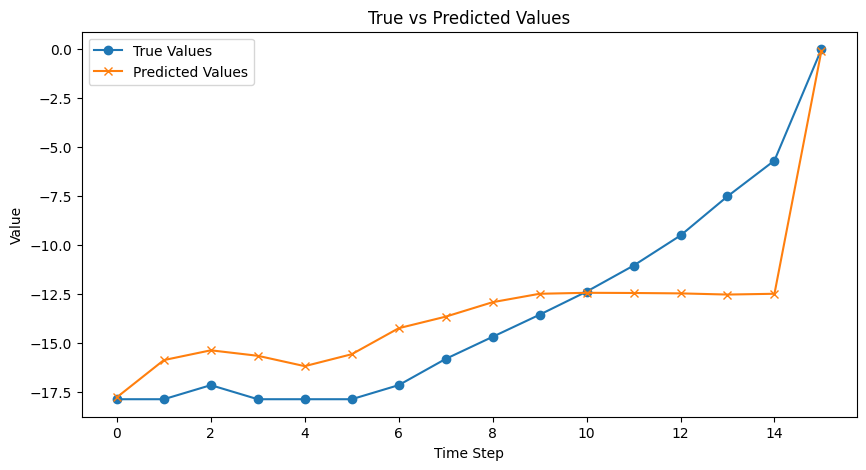

Saved checkpoint: checkpoints/checkpoint_epoch_1500.pth
Epoch 1550, TD Loss: 2.35, MC Loss: 0.57, Total: 2.92     
Epoch 1600, TD Loss: 2.01, MC Loss: 0.21, Total: 2.22     
Epoch 1650, TD Loss: 2.34, MC Loss: 0.27, Total: 2.61     
Epoch 1700, TD Loss: 2.21, MC Loss: 0.53, Total: 2.74     
Epoch 1750, TD Loss: 2.23, MC Loss: 0.36, Total: 2.59     
Epoch 1800, TD Loss: 2.54, MC Loss: 0.24, Total: 2.78     
Epoch 1850, TD Loss: 2.59, MC Loss: 0.33, Total: 2.92     
Epoch 1900, TD Loss: 2.15, MC Loss: 0.2, Total: 2.35      
Epoch 1950, TD Loss: 2.36, MC Loss: 0.38, Total: 2.74     
Epoch 2000, TD Loss: 2.5, MC Loss: 0.22, Total: 2.72      
True Values:
[-17.89 -17.89 -17.17 -17.89 -17.89 -17.89 -17.17 -15.83 -14.7  -13.57 -12.39 -11.06  -9.52  -7.52  -5.69   0.  ]
Predicted Values:
[-17.92 -16.93 -16.07 -15.57 -15.33 -16.01 -13.19 -13.65 -13.27 -13.27 -13.25 -13.28 -13.24 -13.26 -13.29  -0.18]


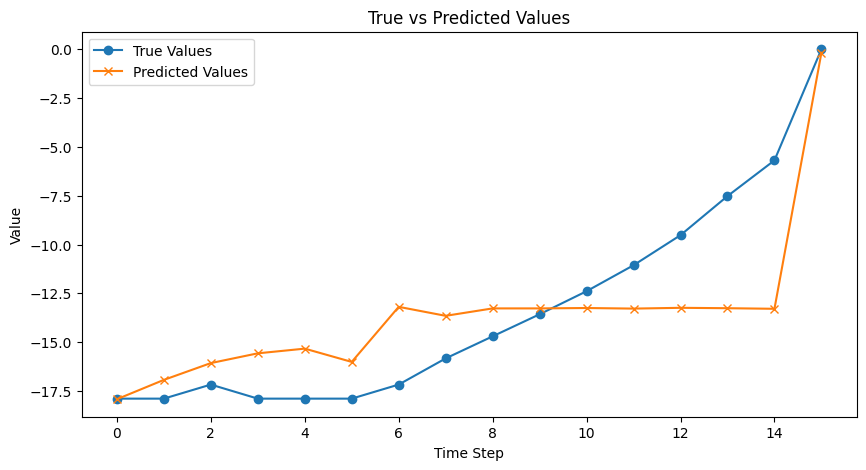

Saved checkpoint: checkpoints/checkpoint_epoch_2000.pth


In [ ]:
RNN_HIDDEN = 64
value_RNN = ValueRNN(input_dim=episodes.H, hidden_dim=RNN_HIDDEN)

train(value_RNN, episodes, test_episode, value_empirical, num_epochs=5001, gamma=1.0, lr=1e-3, validate_every=500, batch_size=5000, indices = [2, None])

## Decode Belief State

In [10]:
def estimate_entropy(belief_states, base=np.e):
    eps = 1e-8  # prevent log(0)
    belief_states = np.clip(belief_states, eps, 1.0)
    log_fn = np.log if base == np.e else lambda x: np.log2(x) if base == 2 else lambda x: np.log(x) / np.log(base)
    
    entropies = -np.sum(belief_states * log_fn(belief_states), axis=1)
    return np.round(np.mean(entropies),2)

entropies = []
for i, belief_indeces in enumerate([[0, 2], [2, None]]):
    all_belief_states = []
    for episode in episodes.episodes:
        all_belief_states.append(np.array(episode.belief_states[:, belief_indeces[0]:belief_indeces[1]]))
    all_belief_states = np.concatenate(all_belief_states, axis=0)
    average_entropy = estimate_entropy(all_belief_states, base=np.e)
    entropies.append(average_entropy)

    print(f"Average Entropy of Belief over states {belief_indeces}:", average_entropy)

Average Entropy of Belief over states [0, 2]: 0.65
Average Entropy of Belief over states [2, None]: 0.79


In [54]:
def decode_training(episodes, belief_decoder, indices, value_RNN=None, num_epochs=1001, lr=1e-3, batch_size=5000):

    if value_RNN is not None:
        histories   = episodes.batch_histories
        mask_traj   = episodes.batch_mask_traj
        with torch.no_grad():
            _, input_to_belief_decoder = value_RNN(histories, mask_traj)
    else:
        input_to_belief_decoder = episodes.batch_histories
    
    loss = train_belief_decoder(belief_decoder, episodes, input_to_belief_decoder, num_epochs=num_epochs, lr=lr, batch_size=batch_size, belief_index=indices)
    print("CE Loss:", np.round(loss, 2), "               ")

    return belief_decoder, loss
    
def decode_visualisation(test_episode, belief_decoder, indices, value_RNN=None):    
    
    if value_RNN is not None:
        pred_belief = evaluate_belief(value_RNN, belief_decoder, test_episode)[0]
    else:
        pred_belief = belief_decoder(torch.tensor(test_episode.history, dtype=torch.float32)).detach().numpy()
    
    print("Belief Decoder:")
    if indices[1] is None:
        plot_decoded_belief_over_true(pred_belief, test_episode, (N, M), belief_index=indices)
    else:
        plot_decoded_belief_over_nuisance(pred_belief, test_episode, belief_index=indices)

    

## Train decoders before RNN

In [58]:
# Iterarate over true and nuisance beliefs
for belief_over in ['true', 'nuisance']:
    print(f"\nDecoding Belief over {belief_over} states")
    output_size = 24 if belief_over == 'true' else 2

    # Iterate over linear and non-linear decoders
    for type in ['lin', 'nonlin']:
        if type == 'lin':
            print("Linear Decoder")
            belief_decoder = LinBeliefDecoder(input_dim=episodes.H, belief_dim=output_size)
        else:
            print("Non-Linear Decoder")
            belief_decoder = NonLinBeliefDecoder(input_dim=episodes.H, hidden_dim=64, belief_dim=output_size)

        belief_decoder, loss = decode_training(
            episodes, belief_decoder, belief_dim_i[belief_over], 
            value_RNN=None, num_epochs=1001, lr=1e-3, batch_size=5000)
        
        if belief_over == 'true':
            if type == 'lin':
                CEb_true_lin = loss
            else:
                CEb_true_nonlin = loss
        else:
            if type == 'lin':
                CEb_nuisance_lin = loss
            else:
                CEb_nuisance_nonlin = loss

        #decode_visualisation(test_episode, belief_decoder, belief_dim_i[belief_over], value_RNN=None)



Decoding Belief over true states
Linear Decoder
CE Loss: 1.98                
Non-Linear Decoder
CE Loss: 1.52                

Decoding Belief over nuisance states
Linear Decoder
CE Loss: 0.67                
Non-Linear Decoder
CE Loss: 0.67                


In [ ]:
EPOCHS = np.arange(0, 2001, 500)

CEs_true_lin = []
CEs_nuisance_lin = []
CEs_true_nonlin = []
CEs_nuisance_nonlin = []

# Iterate over true and nuisance beliefs
for belief_over in ['true', 'nuisance']:
    print(f"\nDecoding Belief over {belief_over} states with Value RNN")
    output_size = 24 if belief_over == 'true' else 2
    
    # Iterate over epochs
    for epoch in EPOCHS:
        # Load the value RNN model from the checkpoint
        model_dict = torch.load(f"checkpoints/checkpoint_epoch_{epoch}.pth", weights_only=True)
        value_RNN.load_state_dict(model_dict['model_state_dict'])
        print(f"Using Value RNN from epoch {epoch}")
        
        # Iterate over linear and non-linear decoders
        for type in ['lin', 'nonlin']:
            if type == 'lin':
                print("Linear Decoder")
                belief_decoder = LinBeliefDecoder(input_dim=value_RNN.hidden_dim, belief_dim=output_size)
            else:
                print("Non-Linear Decoder")
                belief_decoder = NonLinBeliefDecoder(input_dim=value_RNN.hidden_dim, hidden_dim=64, belief_dim=output_size)

            belief_decoder, loss = decode_training(
                episodes, belief_decoder, belief_dim_i[belief_over], 
                value_RNN=value_RNN, num_epochs=1, lr=1e-3, batch_size=5000)
            
            if belief_over == 'true':
                if type == 'lin':
                    CEs_true_lin.append(loss)
                else:
                    CEs_true_nonlin.append(loss)
            else:
                if type == 'lin':
                    CEs_nuisance_lin.append(loss)
                else:
                    CEs_nuisance_nonlin.append(loss)
        
            #decode_visualisation(test_episode, belief_decoder, belief_dim_i[belief_over], value_RNN=value_RNN)


Decoding Belief over true states with Value RNN
Using Value RNN from epoch 0
Linear Decoder
CE Loss: 1.91E Loss: 1.9150
Non-Linear Decoder
CE Loss: 0.94E Loss: 0.9359
Using Value RNN from epoch 500
Linear Decoder
CE Loss: 1.37E Loss: 1.3658
Non-Linear Decoder
CE Loss: 0.88E Loss: 0.8762
Using Value RNN from epoch 1000
Linear Decoder
CE Loss: 1.23E Loss: 1.2317
Non-Linear Decoder
CE Loss: 0.84E Loss: 0.8370
Using Value RNN from epoch 1500
Linear Decoder
CE Loss: 1.5CE Loss: 1.5010
Non-Linear Decoder
CE Loss: 1.1CE Loss: 1.0996
Using Value RNN from epoch 2000
Linear Decoder
CE Loss: 1.52E Loss: 1.5184
Non-Linear Decoder
CE Loss: 1.16E Loss: 1.1614

Decoding Belief over nuisance states with Value RNN
Using Value RNN from epoch 0
Linear Decoder
CE Loss: 0.68E Loss: 0.6797
Non-Linear Decoder
CE Loss: 0.66E Loss: 0.6587
Using Value RNN from epoch 500
Linear Decoder
CE Loss: 0.68E Loss: 0.6789
Non-Linear Decoder
CE Loss: 0.66E Loss: 0.6637
Using Value RNN from epoch 1000
Linear Decoder
CE Lo

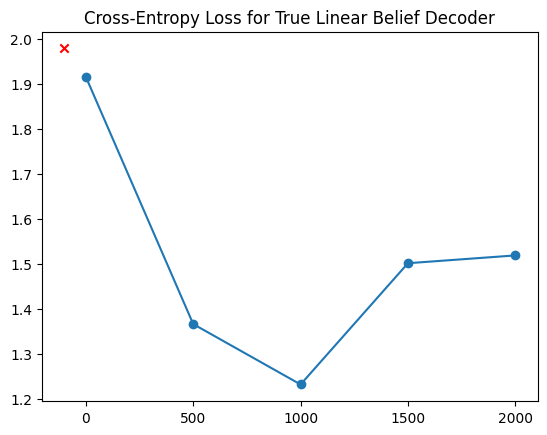

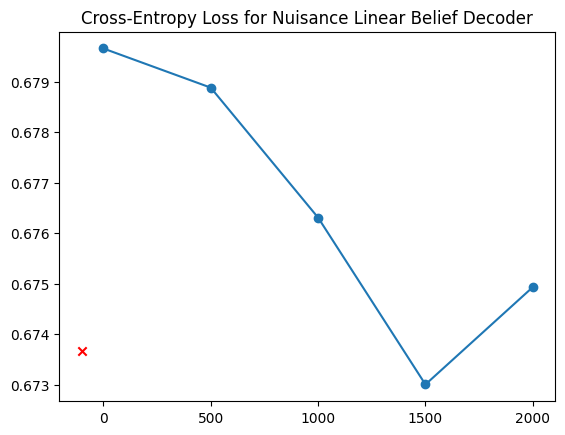

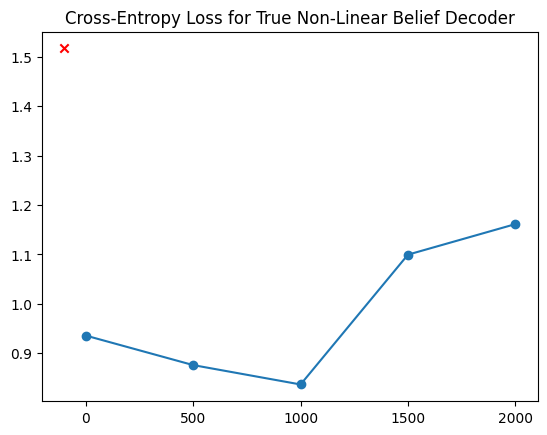

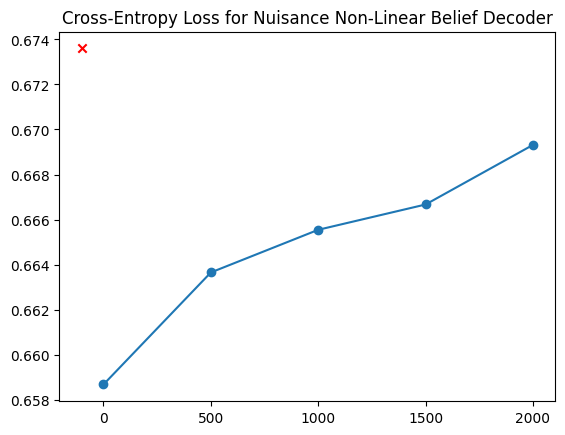

In [60]:
plt.plot(EPOCHS, CEs_true_lin, label='CE True Linear', marker='o')
plt.scatter(-100, CEb_true_lin, color='red', marker='x')
plt.title("Cross-Entropy Loss for True Linear Belief Decoder")
plt.show()
plt.plot(EPOCHS, CEs_nuisance_lin, label='CE Nuisance Linear', marker='o')
plt.scatter(-100, CEb_nuisance_lin, color='red', marker='x')
plt.title("Cross-Entropy Loss for Nuisance Linear Belief Decoder")
plt.show()
plt.plot(EPOCHS, CEs_true_nonlin, label='CE True Non-Linear', marker='o')
plt.scatter(-100, CEb_true_nonlin, color='red', marker='x')
plt.title("Cross-Entropy Loss for True Non-Linear Belief Decoder")
plt.show()
plt.plot(EPOCHS, CEs_nuisance_nonlin, label='CE Nuisance Non-Linear', marker='o')
plt.scatter(-100, CEb_nuisance_nonlin, color='red', marker='x')
plt.title("Cross-Entropy Loss for Nuisance Non-Linear Belief Decoder")
plt.show()